# PREDICCIÓN CHURN POR NODO

## CONTENIDO

* Carga de librerías
 * Configuraciones ambiente de trabajo
* 

## Carga de librerías

In [2]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,  mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
import statsmodels.api as sm
import seaborn as sns

### Configuraciones ambiente de trabajo

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
df= pd.read_csv(f'VW_TRAF_KPIS_DIA_202110190921.csv',sep='|')

In [4]:
df.head(2)

,FEC_MEDICION,DES_AMBITO,DES_SUBAMBITO,COD_EQUIPO,IP_EQUIPO,DES_MUNICIPIO,DES_DEPARTEMENTO,VAL_DIPONIBILIDAD_MAX,VAL_DIPONIBILIDAD_PROM,VAL_LATENCIA_MAX,VAL_LATENCIA_PROM,VAL_JITTER_MAX,VAL_JITTER_PROM,VAL_PLOS_MAX,VAL_PLOS_PROM,VAL_CPU_MAX,VAL_CPU_PROM,VAL_MEM_MAX,VAL_MEM_PROM,VAL_TEMP_MAX,VAL_TEMP_PROM,VAL_LATENCIA_MAX_SONDAS,VAL_LATENCIA_PROM_SONDAS,VAL_JITTER_MAX_SONDAS,VAL_JITTER_PROM_SONDAS,VAL_PLOS_MAX_SONDAS,VAL_PLOS_PROM_SONDAS,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,VAL_EVENTOS_ALTA_PRESION,VAL_EVENTOS_BAJA_PRESION,VAL_EVENTOS_FALLA_COMPRESOR
0,2020-10-17 00:00:00,LTE,CONECTIVIDAD,R7705_PZ-SF-1_LTE_01,10.82.190.40,Aipe,Huila,100.000,100.000,104.620,65.210,0.000,6.290,1.380,0.870,16.000,13.250,31.450,16.000,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0,0,0,0,0,0
1,2020-10-17 00:00:00,LTE,CONECTIVIDAD,R7705_PZ-SF-11_LTE_01,10.82.190.16,Aipe,Huila,100.000,100.000,78.600,67.350,0.000,6.380,0.820,0.480,16.710,12.680,31.460,16.710,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0,0,0,0,0,0


In [5]:
len(df)

821191

In [6]:
# colocar la fecha como index
df.set_index('FEC_MEDICION',inplace=True)

In [7]:
df.index=pd.to_datetime(df.index)

In [8]:
### Calcular minima fecha de eventos

In [9]:
df['totalEventos']=df.filter(regex='^'+'VAL_EVENTOS',axis=1).sum(axis=1)

In [10]:
minFecha=df[df['totalEventos']>0].index.min()
minFecha

Timestamp('2021-09-09 00:00:00')

In [11]:
df=df[df.index>=minFecha]

In [12]:
len(df)

141037

In [13]:
df=df.filter(regex='^'+'VAL_EVENTOS',axis=1)

## Totales

In [14]:
df.head()

,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,VAL_EVENTOS_ALTA_PRESION,VAL_EVENTOS_BAJA_PRESION,VAL_EVENTOS_FALLA_COMPRESOR
FEC_MEDICION,,,,,,
2021-09-09,0,0,0,0,0,0
2021-09-09,0,0,0,0,0,0
2021-09-09,0,0,0,0,0,0
2021-09-09,0,0,0,0,0,0
2021-09-09,0,0,0,0,0,0


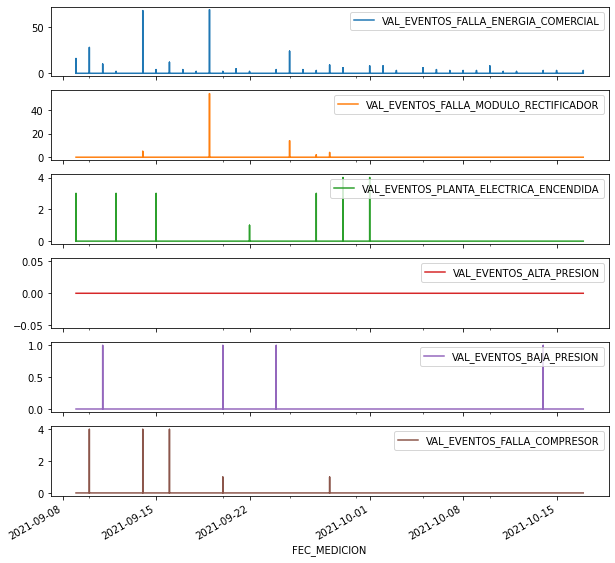

In [15]:
df.plot(subplots=True,figsize=(10,10));

In [16]:
#Unpivot

In [17]:
df_un= df.reset_index().melt(id_vars='FEC_MEDICION', var_name='EVENTO', value_name='VAL')

In [18]:
df_un.head()

,FEC_MEDICION,EVENTO,VAL
0,2021-09-09,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,0
1,2021-09-09,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,0
2,2021-09-09,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,0
3,2021-09-09,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,0
4,2021-09-09,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,0


In [19]:
dfTotales=df_un.groupby(['FEC_MEDICION','EVENTO']).sum()

In [20]:
dfTotales.reset_index(inplace=True)

In [68]:
dfTotales.head()

,EVENTO,VAL
FEC_MEDICION,,
2021-09-09,VAL_EVENTOS_BAJA_PRESION,0
2021-09-09,VAL_EVENTOS_FALLA_COMPRESOR,0
2021-09-09,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,24
2021-09-09,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,0
2021-09-09,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,3


In [22]:
dfTotales.set_index('FEC_MEDICION',inplace=True)

In [73]:
maxFecha=dfTotales.index.max()
maxFecha

Timestamp('2021-10-17 00:00:00')

##  completar series dias dentro del rango

In [78]:
ind = pd.date_range(start=minFecha, end=maxFecha, freq ='D', name='FECHA')[1:]
ind

DatetimeIndex(['2021-09-10', '2021-09-11', '2021-09-12', '2021-09-13',
               '2021-09-14', '2021-09-15', '2021-09-16', '2021-09-17',
               '2021-09-18', '2021-09-19', '2021-09-20', '2021-09-21',
               '2021-09-22', '2021-09-23', '2021-09-24', '2021-09-25',
               '2021-09-26', '2021-09-27', '2021-09-28', '2021-09-29',
               '2021-09-30', '2021-10-01', '2021-10-02', '2021-10-03',
               '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
               '2021-10-08', '2021-10-09', '2021-10-10', '2021-10-11',
               '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15',
               '2021-10-16', '2021-10-17'],
              dtype='datetime64[ns]', name='FECHA', freq='D')

In [85]:
listEventos=dfTotales['EVENTO'].unique()

In [83]:
dfTotalesCom=pd.DataFrame()

In [86]:
i=0
for evento in listEventos:
    aux=dfTotales[dfTotales['EVENTO']==evento]
    aux=aux.reindex(ind, fill_value=0)
    aux['EVENTO']=evento
    if i==0:
        dfTotalesCom=aux
    else:
        dfTotalesCom=dfTotalesCom.append(aux) 
    i=i+1

In [88]:
dfTotalesCom.sample(10)

,EVENTO,VAL
FECHA,,
2021-09-20,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,3
2021-10-02,VAL_EVENTOS_FALLA_COMPRESOR,0
2021-09-12,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,0
2021-09-28,VAL_EVENTOS_BAJA_PRESION,0
2021-09-10,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,0
2021-09-29,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,0
2021-09-11,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,0
2021-10-13,VAL_EVENTOS_FALLA_COMPRESOR,0
2021-10-07,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,0


In [87]:
"""aux=dfTotales[dfTotales['EVENTO']=='VAL_EVENTOS_BAJA_PRESION']
aux=aux.reindex(ind, fill_value=0)
aux['EVENTO']='VAL_EVENTOS_BAJA_PRESION'
aux"""

"aux=dfTotales[dfTotales['EVENTO']=='VAL_EVENTOS_BAJA_PRESION']\naux=aux.reindex(ind, fill_value=0)\naux['EVENTO']='VAL_EVENTOS_BAJA_PRESION'\naux"

##  Separación Entrenamiento y testing

In [89]:
fechaMaxima=max(dfTotalesCom.index)
fechaMaxima

Timestamp('2021-10-17 00:00:00')

In [90]:
dfTotalesCom.index.unique()[-4]

Timestamp('2021-10-14 00:00:00')

In [110]:
fechaTrain=dfTotalesCom.index.unique()[-9]
fechaTest=dfTotalesCom.index.unique()[-8]

In [111]:
print (fechaTrain,fechaTest)

2021-10-09 00:00:00 2021-10-10 00:00:00


In [112]:
# quitar temporalmente VAL_EVENTOS_ALTA_PRESION
dfTotalesCom=dfTotalesCom[dfTotalesCom['EVENTO']!='VAL_EVENTOS_ALTA_PRESION']

In [113]:
TablaTrain=dfTotalesCom[dfTotalesCom.index <= fechaTrain]
TablaTest=dfTotalesCom[dfTotalesCom.index >= fechaTest]

### Indices Entrenamiento

In [114]:
ind = pd.date_range(TablaTrain.index.max(), periods = 9, freq ='D', name='FECHA')[1:]
ind

DatetimeIndex(['2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17'],
              dtype='datetime64[ns]', name='FECHA', freq='D')

In [115]:
dfTotalesCom.index.max()

Timestamp('2021-10-17 00:00:00')

In [116]:
len(dfTotalesCom)

190

In [117]:
dfTotalesCom.nunique()

EVENTO     5
VAL       27
dtype: int64

In [118]:
dfTotalesCom.isnull().sum()

EVENTO    0
VAL       0
dtype: int64

In [119]:
dfTotalesCom.head(3)

,EVENTO,VAL
FECHA,,
2021-09-10,VAL_EVENTOS_BAJA_PRESION,0
2021-09-11,VAL_EVENTOS_BAJA_PRESION,1
2021-09-12,VAL_EVENTOS_BAJA_PRESION,0


## Predicciones

In [171]:
numeroNodos=6
periodosPred=8

In [172]:
final = pd.DataFrame()
finalErrores = {}
grouped =TablaTrain[['EVENTO','VAL']].groupby('EVENTO')
groupedTest =TablaTest[['EVENTO','VAL']].groupby('EVENTO')
#groupedFinal=TablaFinal[['Nodo','Value','MARCACIONES']].groupby('Nodo')

In [173]:
p=groupedTest.get_group('VAL_EVENTOS_BAJA_PRESION')
p

,EVENTO,VAL
FECHA,,
2021-10-10,VAL_EVENTOS_BAJA_PRESION,0
2021-10-11,VAL_EVENTOS_BAJA_PRESION,0
2021-10-12,VAL_EVENTOS_BAJA_PRESION,0
2021-10-13,VAL_EVENTOS_BAJA_PRESION,0
2021-10-14,VAL_EVENTOS_BAJA_PRESION,1
2021-10-15,VAL_EVENTOS_BAJA_PRESION,0
2021-10-16,VAL_EVENTOS_BAJA_PRESION,0
2021-10-17,VAL_EVENTOS_BAJA_PRESION,0


In [174]:
idx = pd.date_range('10-09-2021', '09-10-2021')

In [175]:
metodos=['ARIMA','ES','HOLT','ES_ajTend']

In [176]:
## VAL ES

In [177]:
i=0
for g in grouped.groups:
    print(g)
    if i>numeroNodos*len(metodos):
        continue
    if i/len(metodos)%10==0:
        print(i/len(metodos))    
    dicNodo={} 
    dicAuxMetodo={}
    group = grouped.get_group(g) 
    groupTest = groupedTest.get_group(g) 
    for metodo in metodos:
        if metodo== 'ARIMA':
            model=auto_arima(group['VAL'],trace=False)
            model.fit(group['VAL'])  
            forecast=pd.DataFrame(model.predict(n_periods = periodosPred),index=ind)
        elif metodo== 'ES':
            model = SimpleExpSmoothing(group['VAL'])
            model=model.fit(smoothing_level=.05)
            forecast=pd.DataFrame(model.forecast(periodosPred),index=ind)
        elif metodo== 'HOLT':
            model = Holt(group['VAL']) 
            model = model.fit(optimized=True)
            forecast=pd.DataFrame(model.forecast(periodosPred),index=ind)
        elif metodo== 'ES_ajTend':
            model = ExponentialSmoothing(group['VAL'],trend='add', seasonal=None, damped=True)
            model= model.fit()
            forecast=pd.DataFrame(model.forecast(periodosPred),index=ind)        
        forecast.columns = ['pred']  
        forecast['EVENTO']=g
        forecast['Metodo']=metodo
        #print(forecast)
        #print(groupTest['VAL'])
        if i==0:
            final=forecast
        else:
            final=final.append(forecast)     
        # Errores
        ## Medicion varios errores, seleccionar el que mejor se ajuste
        RMSE=mean_squared_error(groupTest['VAL'],forecast['pred'], squared=False)
        MAPE=mean_absolute_percentage_error(groupTest['VAL'],forecast['pred'])    
        dicNodo[metodo]=RMSE  
        i=i+1
    finalErrores[g]=dicNodo
    

VAL_EVENTOS_BAJA_PRESION
0.0
VAL_EVENTOS_FALLA_COMPRESOR
VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL
VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR
VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA


* Velocidad de procesamiento:  200 Nodos x Minuto

In [178]:
final[final['Metodo']=='ARIMAX2'].head(10)

,pred,EVENTO,Metodo
FECHA,,,


In [179]:
final.isnull().sum()

pred      0
EVENTO    0
Metodo    0
dtype: int64

* No tiene nullos

## Selección mejor método por Nodo

In [180]:
metodos

['ARIMA', 'ES', 'HOLT', 'ES_ajTend']

In [181]:
dfFinalErrores=pd.DataFrame.from_dict(finalErrores,orient='index')
dfFinalErrores.head(10)

,ARIMA,ES,HOLT,ES_ajTend
VAL_EVENTOS_BAJA_PRESION,0.332,0.334,0.379,0.376
VAL_EVENTOS_FALLA_COMPRESOR,0.037,0.345,0.688,0.039
VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,17.440,16.853,13.962,14.120
VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,2.667,2.183,0.331,0.318
VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,0.600,0.566,0.457,0.469


In [182]:
minError=list(dfFinalErrores.min(axis=1).values)
minError[:10]

[0.33166247903554,
 0.03656116555171227,
 13.962224439732832,
 0.3175343456983414,
 0.4568911089474827]

In [183]:
modeloSeleccionado=[np.nan]*len(dfFinalErrores)
i=0
for indx,row in dfFinalErrores.iterrows():
    auxRow=list(row.values)
    auxInd=auxRow.index(minError[i])
    modeloSeleccionado[i]=metodos[auxInd]
    #print(auxRow)
    i=i+1

In [184]:
modeloSeleccionado[:10]

['ARIMA', 'ARIMA', 'HOLT', 'ES_ajTend', 'HOLT']

In [185]:
dfFinalErrores['seleccion']=modeloSeleccionado

In [186]:
dfFinalErrores['errorMin']=minError

In [187]:
dfFinalErrores.head(10)

,ARIMA,ES,HOLT,ES_ajTend,seleccion,errorMin
VAL_EVENTOS_BAJA_PRESION,0.332,0.334,0.379,0.376,ARIMA,0.332
VAL_EVENTOS_FALLA_COMPRESOR,0.037,0.345,0.688,0.039,ARIMA,0.037
VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,17.440,16.853,13.962,14.120,HOLT,13.962
VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,2.667,2.183,0.331,0.318,ES_ajTend,0.318
VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,0.600,0.566,0.457,0.469,HOLT,0.457


In [188]:
dfFinalErrores['seleccion'].value_counts()

ARIMA        2
HOLT         2
ES_ajTend    1
Name: seleccion, dtype: int64

## Predicción Final

In [189]:
#ind_P = pd.date_range(fechaMaxima, periods = 4, freq ='MS', name='FECHA')[1:]
ind_P= pd.date_range(maxFecha, periods = 9, freq ='D', name='FECHA')[1:]
ind_P

DatetimeIndex(['2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-23', '2021-10-24', '2021-10-25'],
              dtype='datetime64[ns]', name='FECHA', freq='D')

In [190]:
finalPrediccionesFuturas = pd.DataFrame()
#groupedPred =dfTotalesCom[['Nodo','Value','MARCACIONES']].groupby('Nodo')
groupedPred=dfTotalesCom[['EVENTO','VAL']].groupby('EVENTO')

In [191]:
p=[1,2,3,4,5,6]
#np.tile(p,3)
p[-3:]
#p.reshape(-1,1)

[4, 5, 6]

In [192]:
i=0
for g in groupedPred.groups:
    if i>numeroNodos:
        continue
    if i%10==0:
        print(i)    
    group = groupedPred.get_group(g)        
    mejorMetodo=dfFinalErrores.loc[g,'seleccion']
    #print(mejorMetodo)
    #metodo=dicMetodos[g][mejorMetodo]
    #forecast=model.predict(group['Value'])
    if mejorMetodo== 'ARIMA':
        model=auto_arima(group['VAL'],trace=False)
        model.fit(group['VAL'])  
        forecast=pd.DataFrame(model.predict(n_periods = periodosPred),index=ind_P)
    elif mejorMetodo== 'ES':
        model = SimpleExpSmoothing(group['VAL'])
        model=model.fit(smoothing_level=.5)
        forecast=pd.DataFrame(model.forecast(periodosPred),index=ind_P)
    elif mejorMetodo== 'HOLT':
        model = Holt(group['VAL']) 
        model = model.fit(optimized=True)
        forecast=pd.DataFrame(model.forecast(periodosPred),index=ind_P)
    elif mejorMetodo== 'ES_ajTend':
        model = ExponentialSmoothing(group['VAL'],trend='add', seasonal=None, damped=True)
        model= model.fit()
        forecast=pd.DataFrame(model.forecast(periodosPred),index=ind_P)    
    
    forecast.columns = ['pred'] 
    forecast['EVENTO']=g
    forecast['Metodo']=mejorMetodo

    if i==0:
        finalPrediccionesFuturas=forecast
    else:
        finalPrediccionesFuturas=finalPrediccionesFuturas.append(forecast) 
    i=i+1
        

0


In [193]:
#Reemplazar positivos por cero
finalPrediccionesFuturas['pred']=np.where(finalPrediccionesFuturas['pred']>0,0,finalPrediccionesFuturas['pred'])

*  Velocidad de procesamiento 650 por minuto

In [194]:
finalPrediccionesFuturas.sample(10)

,pred,EVENTO,Metodo
FECHA,,,
2021-10-19,0.000,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,HOLT
2021-10-23,-0.004,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,HOLT
2021-10-21,0.000,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,HOLT
2021-10-24,-1.241,VAL_EVENTOS_FALLA_MODULO_RECTIFICADOR,ES_ajTend
2021-10-25,-0.609,VAL_EVENTOS_FALLA_COMPRESOR,ARIMA
2021-10-24,-0.023,VAL_EVENTOS_PLANTA_ELECTRICA_ENCENDIDA,HOLT
2021-10-23,0.000,VAL_EVENTOS_BAJA_PRESION,ARIMA
2021-10-18,0.000,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,HOLT
2021-10-19,0.000,VAL_EVENTOS_FALLA_ENERGIA_COMERCIAL,HOLT


In [195]:
resultadoFinal=finalPrediccionesFuturas.reset_index().merge(maestroNodo,left_on='Nodo',right_on='Nodo',how='left')
resultadoFinal.head(5)

NameError: name 'maestroNodo' is not defined

In [196]:
resultadoFinal.to_csv('resultadoPrediciones.csv')

NameError: name 'resultadoFinal' is not defined

## Visualizar Resultado Nodo

In [197]:
def visualNodo(nodo):
    print(finalErrores[nodo])
    dfNodo_real=dfTotalesCom[dfTotalesCom['EVENTO']==nodo][['VAL']]
    dfNodo=final[final['EVENTO']==nodo]
    dfNodo= pd.pivot_table(dfNodo.reset_index(), index='FECHA', columns='Metodo', values='pred')    
    dfNodo_real=dfNodo_real.merge(dfNodo,left_index=True, right_index=True, how='left')
    dfPrediciciones=finalPrediccionesFuturas[finalPrediccionesFuturas['EVENTO']==nodo]
    metodoSel=dfPrediciciones['Metodo'].unique()[0]
    dfPrediciciones.rename(columns={'pred':'pred_'+metodoSel},inplace=True)   
    dfNodo_real.merge(dfPrediciciones[['pred_'+metodoSel]],left_index=True, right_index=True,how='outer').plot()

{'ARIMA': 0.33166247903554, 'ES': 0.33384263203367054, 'HOLT': 0.37903065785254325, 'ES_ajTend': 0.37573640180812906}
{'ARIMA': 0.03656116555171227, 'ES': 0.34549811510921097, 'HOLT': 0.6883043009677494, 'ES_ajTend': 0.03878140451148291}
{'ARIMA': 17.440024209972997, 'ES': 16.853222624618724, 'HOLT': 13.962224439732832, 'ES_ajTend': 14.1200784408942}
{'ARIMA': 2.666666666666666, 'ES': 2.18309321252447, 'HOLT': 0.33061470772806645, 'ES_ajTend': 0.3175343456983414}
{'ARIMA': 0.5999999999999999, 'ES': 0.5658590368701495, 'HOLT': 0.4568911089474827, 'ES_ajTend': 0.4687976823978161}


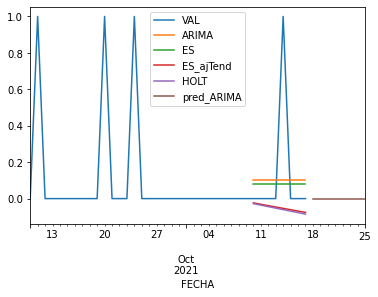

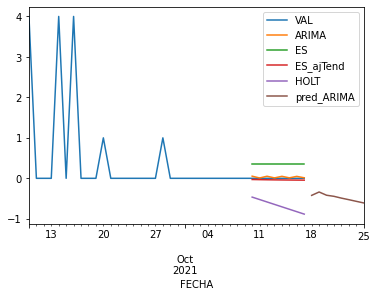

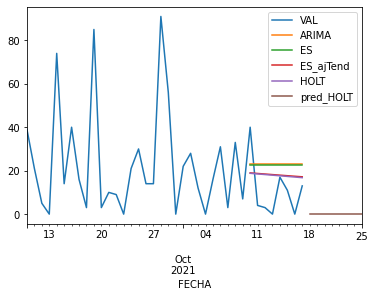

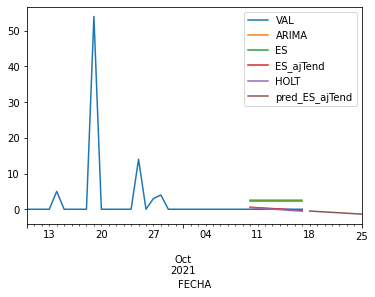

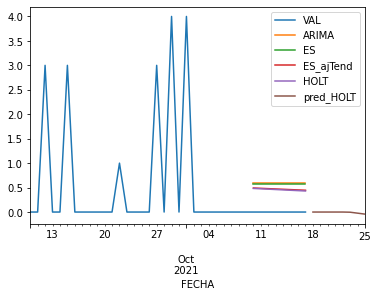

In [199]:
for evento in listEventos:
    visualNodo(evento)

{'ARIMA': 0.33166247903554, 'ES': 0.33384263203367054, 'HOLT': 0.37903065785254325, 'ES_ajTend': 0.37573640180812906}


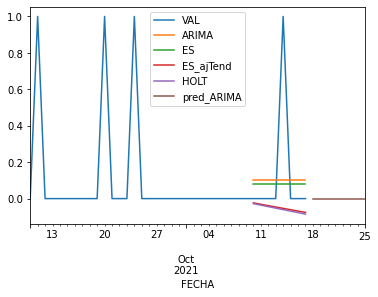

In [198]:
visualNodo('VAL_EVENTOS_BAJA_PRESION')

## Descripción del Resultado

In [ ]:
finalPrediccionesFuturas['Metodo'].value_counts()/3

In [ ]:
pieChart(finalPrediccionesFuturas['Metodo'])

In [ ]:
dfFinalErrores['errorMin'].hist()

In [ ]:
maxBin=dfFinalErrores['errorMin'].max()
bins=[0,1,2,5,10,20,maxBin]

In [ ]:
dfFinalErrores['binError']=pd.cut((dfFinalErrores['errorMin']),bins=np.sort(bins),right=True)

In [ ]:
dfFinalErrores.head(10)

In [ ]:
dfFinalErrores['binError'].value_counts()

In [ ]:
dfFinalErrores[['binError']].value_counts().sort_index(ascending=False).plot.barh()

#### Analisis preducciones futuras

In [ ]:
finalPrediccionesFuturas['pred'].hist()

In [ ]:
finalPrediccionesFuturas['pred'].describe()

In [ ]:
sns.violinplot(x=finalPrediccionesFuturas['pred']);

In [ ]:
minBin=finalPrediccionesFuturas['pred'].min()
bins=[minBin,-50,-30,-20,-10,-5,0,15]
finalPrediccionesFuturas['binPred']=pd.cut((finalPrediccionesFuturas['pred']),bins=np.sort(bins),right=True)
#finalPrediccionesFuturas['binPred']=pd.cut((finalPrediccionesFuturas['pred']),bins=5,right=True)

In [ ]:
finalPrediccionesFuturas['binPred'].value_counts()

In [ ]:
pieChart(finalPrediccionesFuturas['binPred'])

In [ ]:
dfGraf=finalPrediccionesFuturas.reset_index()[['FECHA','pred','Nodo']]

In [ ]:
dfGraf['FECHA']=dfGraf['FECHA'].astype(str)
dfGraf.head(10)

In [ ]:
sns.violinplot(x='FECHA', y='pred', data=dfGraf, inner="quart", linewidth=1)

In [ ]:
dfGraf=pd.pivot_table(dfGraf,index='Nodo',columns='FECHA',values='pred',aggfunc=np.sum)

In [ ]:
dfGraf.describe().T

### Resumen por nodo

In [ ]:
ResPred=finalPrediccionesFuturas.groupby('Nodo').sum()

In [ ]:
minBin=ResPred['pred'].min()
bins=[minBin-1,-150,-100,-50,-20,0,50]
ResPred['binPred']=pd.cut((ResPred['pred']),bins=np.sort(bins),right=True)
#ResPred['binPred']=pd.cut((ResPred['pred']),bins=5,right=True)

In [ ]:
ResPred['binPred'].value_counts()

In [ ]:
pieChart(ResPred['binPred'])

In [ ]:
ResPred.head(2)

#### Predicciones por distrito

In [ ]:
pt=ResPred.merge(maestroNodo,left_index=True,right_on='Nodo',how='left')
pt.head()

In [ ]:
pt=pd.pivot_table(pt,columns='binPred',index='E_distrito', fill_value=0)

In [ ]:
pt

In [ ]:
pt.sum(axis=1).sort_values()

##  Revisión casos atípicos
* Mayores errores en los metodos

In [ ]:
dfFinalErrores[dfFinalErrores['errorMin']>=20]

In [ ]:
for key, row in dfFinalErrores[dfFinalErrores['errorMin']>=20].iterrows():
    print(key)
    visualNodo(key)

* Churn más bajos

In [ ]:
finalPrediccionesFuturas[finalPrediccionesFuturas['pred']<=-50]

In [ ]:
for key, row in ResPred[ResPred['pred']<=-100].iterrows():
    print(key)
    visualNodo(key)

### Validacion

In [206]:
atest=[3,np.nan,6]
atest=[3]
apred=[4, 2, 5]

In [207]:
atest

[3]

In [208]:
RMSE=mean_squared_error(atest,apred, squared=False)
MAPE=mean_absolute_percentage_error(atest,apred)

ValueError: Found input variables with inconsistent numbers of samples: [1, 3]